# GSF Training Model

In [1]:
import pandas as pd
import random
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
import selfies as sf
import group_selfies as gsf
from rdkit import Chem

random.seed(42)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:

import optuna
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    make_scorer,
    roc_curve,
    auc,
    hamming_loss,
    jaccard_score,
)
import matplotlib.pyplot as plt


/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Processing

In [3]:
chembl_df = pd.read_csv("../../data/ExperimentData/pChEMBL_data.csv")
print(chembl_df.head())

  Molecule ChEMBL ID                                       Smiles  \
0      CHEMBL1643678   Fc1ccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)cc1   
1      CHEMBL1643853  COc1cccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)c1   
2      CHEMBL1643672             c1cc2nc3c(c(N4CCCCC4)n2n1)CCNCC3   
3      CHEMBL2022190          Cl.NC[C@H]1C[C@@H]1c1ccccc1OCC1CCC1   
4      CHEMBL2022193           Cl.NC[C@@H]1C[C@H]1c1ccccc1OCC1CC1   

   pChEMBL Value     Comment  
0           8.52         NaN  
1           7.40         NaN  
2           6.23         NaN  
3            NaN  Not Active  
4            NaN  Not Active  


## process the data -> split to psy and non-psy

In [4]:
filtered_df = chembl_df[chembl_df["Comment"] != "Not Determined"]
filtered_df.fillna(0, inplace=True)
print(filtered_df.shape)

# check psy ad non-psy number
psy_chembl = filtered_df[filtered_df["pChEMBL Value"] == 0].drop(["Comment"], axis=1)
non_psy_chembl = filtered_df[filtered_df["pChEMBL Value"] != 0].drop(["Comment"], axis=1)

print(psy_chembl.shape)
print(non_psy_chembl.shape)

combine_psy_nonpsy = filtered_df.drop(["Comment"], axis=1)
print(combine_psy_nonpsy.head())    

(1260, 4)
(314, 3)
(946, 3)
  Molecule ChEMBL ID                                       Smiles  \
0      CHEMBL1643678   Fc1ccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)cc1   
1      CHEMBL1643853  COc1cccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)c1   
2      CHEMBL1643672             c1cc2nc3c(c(N4CCCCC4)n2n1)CCNCC3   
3      CHEMBL2022190          Cl.NC[C@H]1C[C@@H]1c1ccccc1OCC1CCC1   
4      CHEMBL2022193           Cl.NC[C@@H]1C[C@H]1c1ccccc1OCC1CC1   

   pChEMBL Value  
0           8.52  
1           7.40  
2           6.23  
3           0.00  
4           0.00  


/var/folders/qx/gfkzkrms53g36y6nnlpc2t2c0000gn/T/ipykernel_96376/1542438518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.fillna(0, inplace=True)


## Extract group tokan by autofragmentation

In [5]:
# data preparation for fragmenting using X_train
SMILES_autofragmentation = combine_psy_nonpsy["Smiles"].tolist()

print(SMILES_autofragmentation)

['Fc1ccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)cc1', 'COc1cccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)c1', 'c1cc2nc3c(c(N4CCCCC4)n2n1)CCNCC3', 'Cl.NC[C@H]1C[C@@H]1c1ccccc1OCC1CCC1', 'Cl.NC[C@@H]1C[C@H]1c1ccccc1OCC1CC1', 'Cl.NC[C@H]1C[C@@H]1c1ccccc1OCC1CC1', 'Clc1cccc(N2CCNCC2)c1', 'COc1cc(Cl)c2c(c1)[C@@H]1CNCCN1C2=O', 'CCc1cc(Cl)c2c(c1)[C@@H]1CNCCN1C2=O', 'CCc1cc2c(ccc3cnn(C[C@H](C)N)c32)o1', '[2H]C([2H])([2H])N1CCC[C@@H]1Cc1c[nH]c2cccc(O)c12', 'CN1CCC[C@@H]1Cc1c[nH]c2cccc(O)c12', 'Cl.Oc1ccc(O)c(C2NCCc3c2[nH]c2ccc(F)cc32)c1', 'Clc1ccc2[nH]c3c(c2c1)CCNC3c1ccccc1', 'Cl.Oc1ccc(C2NCCc3c2[nH]c2ccc(Cl)cc32)cc1', 'Cl.Fc1ccc2[nH]c3c(c2c1)CCNC3c1ccccc1F', 'Cl.Oc1ccccc1C1NCCc2c1[nH]c1ccc(Cl)cc21', 'Cc1noc(C)c1C1NCCc2c1[nH]c1ccc(F)cc21.Cl', 'Cc1cc(C2NCCc3c2[nH]c2ccc(Cl)cc32)sc1Br.Cl', 'CC1CNCCc2cc(F)c(Cl)cc21', 'Oc1cccc2[nH]cc(CCN3CCC3)c12', 'CC1CNCCc2cc(O)c(Br)cc21', 'CC1CNCCc2c(Cl)cccc21', 'Clc1ccccc1O[C@H]1CCCc2ccc(N3CCNCC3)nc21', 'C[C@@H]1CNC[C@H]2Cc3ccc(COCC4CC4)nc3N21', 'CC1CNCCc2ccc(C(F)(F)F)cc21', 'CC

### mmpa

In [6]:
molecules = [Chem.MolFromSmiles(smiles) for smiles in SMILES_autofragmentation]

# extracting a set of reasonable groups using fragmentation
fragments_mmpa = gsf.fragment_mols(molecules, method="mmpa")

# create a dictionary of fragments for tracking
vocab_fragment_mmpa = dict(
    [
        (f"frag{idx}", gsf.Group(f"frag{idx}", frag))
        for idx, frag in enumerate(fragments_mmpa)
    ]
)

print(fragments_mmpa)
print(len(fragments_mmpa))


100%|██████████| 1260/1260 [03:07<00:00,  6.71it/s]


['C1C(*1)CN1*1', 'C1=C(OC(*1)*1)C(C2(*1)C[C@@H]2*1)=C(*1)C(*1)=C1*1', 'COC1=CC=C(*1)C=C1C1(*1)CC1*1', 'C1=C(OC(*1)*1)C([C@H]2C[C@@H]2*1)=CC(*1)=C1', 'C1=C(OC(*1)*1)C(C2(*1)C[C@@H]2CN(*1)*1)=C(*1)C(*1)=C1*1', 'COC1=CC=C(*1)C=C1C1(*1)CC1CN*1', 'C1=C(OC*1)C([C@H]2C[C@@H]2CN(*1)*1)=CC(*1)=C1', 'C([C@@H]1C(C2=C(*1)C(*1)=C(*1)C(*1)=C2*1)(*1)C1(*1)*1)N(*1)*1', 'NC[C@H]1C[C@@]1(C1=CC=CC=C1*1)*1', 'C1[C@H](CN(*1)*1)[C@H]1C1=C(*1)C(*1)=C(*1)C(*1)=C1*1', 'C1=CC2=C(C=C1*1)C(*1)=NN2*1', 'N1=C(*1)C2=C(N1)C(*1)=C(*1)C(*1)=C2*1', 'FC1=C(*1)C=C(O*1)C(C2(*1)C[C@@H]2C*1)=C1*1', 'FC1=CC=C(O*1)C([C@@H]2C[C@H]2C*1)=C1', 'C1=C2C(=CC=C1*1)N(*1)N=C2*1', 'C1=C2NN=C(*1)C2=CC(*1)=C1*1', 'C1=C(*1)C2=C(C(*1)=C(*1)C(*1)=C2*1)N1*1', 'C1=C(*1)C2=C(N1)C(*1)=C(*1)C(*1)=C2*1', 'C1=C(C(N(C[C@H]2C[C@@H]2C2=CC(*1)=CC=C2*1)*1)*1)C(*1)=CC=C1*1', 'C1=CC=C(*1)C(CNC[C@H]2CC2(C2=CC(*1)=CC=C2*1)*1)=C1', 'C1=CC=C(C(N(C[C@H]2C[C@@H]2C2=CC(*1)=CC=C2OC*1)*1)*1)C(OC*1)=C1', 'COC1=CC=CC=C1CNCC1CC1(C1=CC(*1)=CC=C1OC)*1', 'C1=CC(*1)=C(*1)

In [7]:
grammar_auto_mmpa = gsf.GroupGrammar(vocab=vocab_fragment_mmpa)

### mmpa fragmentation on chembl data

In [8]:
encode_input = [Chem.MolFromSmiles(smiles) for smiles in combine_psy_nonpsy["Smiles"]]

In [9]:
group_selfie_mmpa = []
extracted_groups_mmpa = []


for smiles in encode_input:
    encode_mol = grammar_auto_mmpa.full_encoder(smiles)
    group_selfie_mmpa.append(encode_mol)
    extracted = grammar_auto_mmpa.extract_groups(smiles)
    extracted_group = [group.name for group, _, _ in extracted]
    extracted_groups_mmpa.append(extracted_group)
    print(extracted_group)

print(extracted_groups_mmpa)


['frag94', 'frag66', 'frag42']
['frag94', 'frag66', 'frag0', 'frag42']
['frag66', 'frag42', 'frag42']
['frag94']
['frag6']
['frag94']
['frag48']
['frag94', 'frag42']
['frag42']
['frag66']
[]
['frag42']
['frag71']
['frag71']
['frag71']
['frag71']
['frag71']
['frag71']
['frag71', 'frag58']
['frag42']
['frag22']
['frag42']
['frag42']
['frag48']
[]
['frag42']
['frag42']
['frag42']
['frag94', 'frag42']
['frag13']
['frag94', 'frag42']
['frag94', 'frag42']
['frag42']
['frag42']
['frag42']
['frag94']
['frag94']
['frag94']
['frag94']
[]
[]
['frag42']
['frag42']
['frag70', 'frag55']
['frag70', 'frag55']
['frag83']
['frag42']
['frag94', 'frag42']
[]
['frag42']
['frag91']
[]
['frag42']
['frag42']
[]
['frag42']
['frag42']
['frag42']
['frag42']
['frag42']
[]
[]
[]
[]
[]
[]
['frag94']
['frag94']
[]
['frag42']
['frag42']
['frag95']
['frag85']
['frag94']
['frag24', 'frag94']
['frag24', 'frag94']
['frag24']
['frag5', 'frag2']
['frag53']
[]
[]
['frag69']
['frag52']
['frag56']
['frag100']
['frag32']
['fra

### one-hot encoding

In [10]:
# Convert to DataFrame with a single column
df = pd.DataFrame({"Fragments": extracted_groups_mmpa})

# Explode the lists to get one fragment per row
df_exploded = df.explode("Fragments")

# Perform one-hot encoding
one_hot = pd.get_dummies(df_exploded["Fragments"], prefix="frag")

# Group by the original index to aggregate back to list-level encoding
one_hot_encoded = one_hot.groupby(level=0).max().astype(int)

# Print the result
print(one_hot_encoded)
one_hot_encoded.to_csv("psy_nonpsy_onehot.csv")


      frag_frag0  frag_frag100  frag_frag11  frag_frag13  frag_frag14  \
0              0             0            0            0            0   
1              1             0            0            0            0   
2              0             0            0            0            0   
3              0             0            0            0            0   
4              0             0            0            0            0   
...          ...           ...          ...          ...          ...   
1255           0             0            0            0            0   
1256           0             0            0            0            0   
1257           0             0            0            0            0   
1258           0             0            0            0            0   
1259           0             0            0            0            0   

      frag_frag15  frag_frag16  frag_frag2  frag_frag20  frag_frag21  ...  \
0               0            0           0    

# Training

In [11]:
X = one_hot_encoded
y_label = (combine_psy_nonpsy["pChEMBL Value"] > 0).astype(int)
y_value = combine_psy_nonpsy["pChEMBL Value"]


print(X.shape, y_label.shape, y_value.shape)
print(X.head())
print(y_label.head())


(1260, 62) (1260,) (1260,)
   frag_frag0  frag_frag100  frag_frag11  frag_frag13  frag_frag14  \
0           0             0            0            0            0   
1           1             0            0            0            0   
2           0             0            0            0            0   
3           0             0            0            0            0   
4           0             0            0            0            0   

   frag_frag15  frag_frag16  frag_frag2  frag_frag20  frag_frag21  ...  \
0            0            0           0            0            0  ...   
1            0            0           0            0            0  ...   
2            0            0           0            0            0  ...   
3            0            0           0            0            0  ...   
4            0            0           0            0            0  ...   

   frag_frag85  frag_frag87  frag_frag88  frag_frag89  frag_frag91  \
0            0            0          

### Real Value Threshold

In [15]:
# Outer cross-validation (model evaluation)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_scores = []

# Inner cross-validation (hyperparameter tuning)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)


def objective(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_categorical("max_depth", [None, 10, 20])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    threshold = trial.suggest_float(
        "threshold", 0, 5
    )  # Threshold for binary classification

    # Random Forest model
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
    )

    inner_scores = []
    # Evaluate using inner CV
    for train_idx, val_idx in inner_cv.split(X_train):
        X_train_inner, X_val_inner = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_inner, y_val_inner = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit the model
        rf.fit(X_train_inner, y_train_inner)

        # Predict real values
        y_pred_inner = rf.predict(X_val_inner)

        # Apply threshold to convert real values to binary classification
        y_pred_inner_bool = (y_pred_inner >= threshold).astype(int)
        y_val_inner_bool = (y_val_inner >= threshold).astype(int)

        # Calculate Hamming Loss
        accuracy_inner = accuracy_score(y_val_inner_bool, y_pred_inner_bool)

        # Append score
        inner_scores.append(accuracy_inner)

    return np.mean(inner_scores)


# Outer loop
for train_idx, test_idx in outer_cv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_value.iloc[train_idx], y_value.iloc[test_idx]

    # Optuna hyperparameter tuning
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)

    # Train the best model on the full training set
    best_params = study.best_params
    best_rf = RandomForestRegressor(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        random_state=42,
    )
    best_rf.fit(X_train, y_train)

    # Evaluate on the test set
    y_pred = best_rf.predict(X_test)

    # Apply optimized threshold for classification
    threshold = study.best_trial.params["threshold"]
    y_pred_binary = (y_pred >= threshold).astype(int)
    y_test_binary = (y_test >= threshold).astype(int)

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred)  
    roc_auc = auc(fpr, tpr)

    # Store all scores
    outer_scores.append(
        {
            "accuracy": accuracy_score(y_test_binary, y_pred_binary),
            "f1_score": f1_score(y_test_binary, y_pred_binary, average="weighted"),
            "roc_auc": roc_auc,
        }
    )
    # # Plot ROC curve for the current fold
    # plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {roc_auc:.2f})", alpha=0.7)


[I 2025-01-11 16:23:01,481] A new study created in memory with name: no-name-d00d1920-8d68-4984-8886-fb1430d9104c
[I 2025-01-11 16:23:02,069] Trial 0 finished with value: 0.7936505590857593 and parameters: {'n_estimators': 95, 'max_depth': 20, 'min_samples_split': 9, 'threshold': 0.764633221636627}. Best is trial 0 with value: 0.7936505590857593.
[I 2025-01-11 16:23:02,926] Trial 1 finished with value: 0.7926752376730211 and parameters: {'n_estimators': 116, 'max_depth': None, 'min_samples_split': 2, 'threshold': 0.45531917111053255}. Best is trial 1 with value: 0.7926752376730211.
[I 2025-01-11 16:23:03,798] Trial 2 finished with value: 0.8035909561105363 and parameters: {'n_estimators': 120, 'max_depth': None, 'min_samples_split': 3, 'threshold': 2.2909857042434236}. Best is trial 1 with value: 0.7926752376730211.
[I 2025-01-11 16:23:04,422] Trial 3 finished with value: 0.7986256834638688 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 4, 'threshold': 1.11

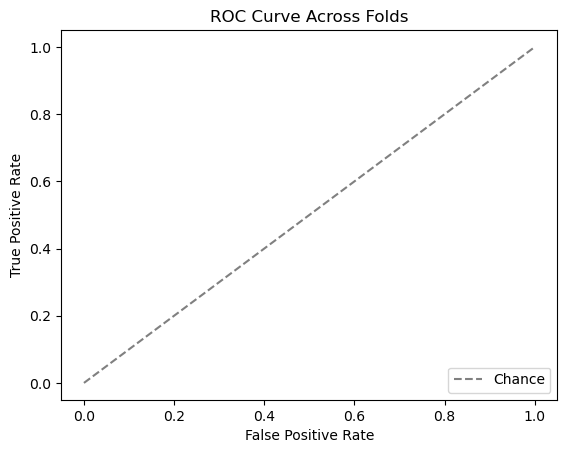

Fold 1:
  accuracy: 0.6706
  f1_score: 0.6878
  roc_auc: 0.7509


In [ ]:
# # Finalize ROC plot
# plt.plot(
#     [0, 1], [0, 1], linestyle="--", color="gray", label="Chance"
# )  # 绘制对角线基准线
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve Across Folds")
# plt.legend(loc="lower right")
# plt.show()

# Print final scores
for i, scores in enumerate(outer_scores):
    print(f"Fold {i+1}:")
    for metric, value in scores.items():
        print(f"  {metric}: {value:.4f}")


In [83]:
print(best_params)

{'n_estimators': 98, 'max_depth': 20, 'min_samples_split': 7, 'threshold': 4.976036778419654}
